## Imports


In [337]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay,roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

from imblearn.over_sampling import SMOTE



SEED=0

In [338]:
diab = pd.read_csv('../diabetes_prediction_dataset.csv')
display(diab.head())

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## DataCleaning

In [339]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in diab.columns:
    if diab[col].dtype in ["int64", "float64"]:
        invalid_values[col] = [
            diab[col].isnull().sum(),
            diab[col].isna().sum(),
            (diab[col] < 0).sum(),
        ]
    else:
        invalid_values[col] = [diab[col].isnull().sum(), diab[col].isna().sum(), np.NaN]
invalid_values.index = ["Null count", "NaN count", "Negative count"]

display(invalid_values)
print("There are no null, NaN, or negative values in the dataset that need cleaning.\n")

print(f"Duplicated Rows: {diab.duplicated().sum()}")
# There are 3854 duplicate rows, let's drop them
diab_clean = diab.drop_duplicates().copy(True)

# There are 3998 "ever" values in the 'smoking_history' column, this looks like a typo
# So let's replace it with 'never'
print(
    f"""
There are {len(diab_clean[diab_clean['smoking_history'] == 'ever'])} "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".
"""
)
diab_clean.loc[diab_clean["smoking_history"] == "ever", "smoking_history"] = "never"

diab_clean["smoking_history_num"] = diab_clean["smoking_history"].map(
    {
        "No Info": 0,
        "never": 1,
        "former": 2,
        "not current": 3,
        "current": 4,
    }
)

diab_clean["gender_num"] = diab_clean["gender"].map(
    {
        "Male": 0,
        "Female": 1,
        "Other": 2,
    }
)

print(f"There are {len(diab_clean)} clean rows left after dropping duplicates.")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854

There are 3998 "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".

There are 96146 clean rows left after dropping duplicates.


## Model Implementation And Analysis 

In [340]:
class ModelAnalysis:
    def __init__(self, models):
        self.models = models 

    def modelAnalysisSummary(self):
        modelsName = []
        preMacro = []
        recMacro=[]
        f1Macro=[]
        preWeighted=[]
        recWeighted=[]
        f1Weighted=[]

        for model in self.models:
            modelsName.append(model.name)
            report = model.report

            preMacro.append(report['precision']['macro avg'])
            recMacro.append(report['recall']['macro avg'])
            f1Macro.append(report['f1-score']['macro avg'])
            preWeighted.append(report['precision']['weighted avg'])
            recWeighted.append(report['recall']['weighted avg'])
            f1Weighted.append(report['f1-score']['weighted avg'])
        
        self.modelsReportData = {
            'Model': modelsName,
            'Precision (Macro)': preMacro,
            'Recall (Macro)': recMacro,
            'F1-Score (Macro)': f1Macro,
            "Precision (Weighted)": preWeighted,
            "Recall (Weighted)" : recWeighted,
            "F1-Score (Weighted)": f1Weighted
        }

        self.modelsReportDataFrame = pd.DataFrame(self.modelsReportData)
        display(self.modelsReportDataFrame.round(2))    
    
    def overAllMetricsPlot(self):
        df_print = self.modelsReportDataFrame.copy(deep=True)
        df_print.set_index("Model", inplace=True)
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        df_print[["Precision (Weighted)", "Recall (Weighted)", "F1-Score (Weighted)"]].plot(
            kind="barh", ax=axes[0], colormap="Pastel2")
        axes[0].set_title("Model Performance (Weighted Metrics)")
        axes[0].set_xlabel("Score")
        axes[0].set_xlim(0, 1.05)
        axes[0].invert_yaxis()
        
        df_print[["Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)"]].plot(
            kind="barh", ax=axes[1], colormap="Pastel1"
        )
        axes[1].set_title("Model Performance (Macro Metrics)")
        axes[1].set_xlabel("Score")
        axes[1].set_xlim(0, 1.05)
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.show()
            

    def plottingMacroAndWeightedAvgs(self):
        metrics = ['Precision', 'Recall', 'F1-Score']
        fig, axes = plt.subplots(1, 3, figsize=(20,8))
        for idx, metric in enumerate(metrics):
            df_plot = self.modelsReportDataFrame.set_index("Model")[[f"{metric} (Macro)", f"{metric} (Weighted)"]]
            df_plot.plot(kind="barh", ax=axes[idx], colormap="Set2")
            axes[idx].set_title(f"{metric} - Macro vs Weighted")
            axes[idx].set_xlabel("Score")
            axes[idx].invert_yaxis()
        plt.tight_layout()
        plt.show()



class Model:
    def __init__(self, name):
        self.name = name    
   
    def report_model_performance(self):
        self.accuracy = accuracy_score(self.y_test, self.y_modelPredict)
        print(f"{self.name} Accuracy: {self.accuracy:.2f}")
        self.report = pd.DataFrame(classification_report(self.y_test, self.y_modelPredict, target_names=["No Diabetes", "Diabetes"], output_dict=True)).T        
        print(self.report.round(2))  
        self.confusionMatrix()        

    def confusionMatrix(self):
        cm = confusion_matrix(self.y_test, self.y_modelPredict)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for {self.name}")
        plt.show()
        

    def rocCurve(self):
        fpr, tpr,_ = roc_curve(self.y_test, self.y_prob)        
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= self.name).plot()
        plt.title('ROC Curve')
        plt.show()

    
    def precisionRecallCurve(self):
        precision, recall,_= precision_recall_curve(self.y_test, self.y_prob)
        avg_prec = average_precision_score(self.y_test, self.y_prob)
        PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_prec).plot()
        plt.show()
                        
    def testTrainSplit(self, features, labels, testSize):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            features, labels, test_size=0.2
        )   

    def predict(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_modelPredict = func(val)        
    
    def predictProb(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_prob = func(self.x_test)[:,1]

### Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76908
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23328.
Date:                Mon, 16 Jun 2025   Deviance:                       46657.
Time:                        22:52:54   Pearson chi2:                 2.07e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          -0.008101
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
HbA1c_level            -0.1707      0.009    -18.652      0.000      -0.189      -0.153
blood_glucose_level     0.0101      0.000     36.126      0.000       0.010       0.011
age                     0.0179      0.001     29.283      0.000       0.017       0.019
bmi                    -0.1205      0.002    -56.380      0.000      -0.125      -0.116
smoking_history_num    -0.0108      0.010     -1.055      0.292      -0.031       0.009
heart_disease           0.9529      0.045     21.017      0.000       0.864       1.042
hypertension            1.2640      0.036     35.105      0.000       1.193       1.335
gender_num             -0.8319      0.024    -34.159      0.000      -0.880      -0.784
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.91
              precision  recall  f1-score   support
No Diabetes        0.92    0.99      0.95  17562.00
Diabetes           0.46    0.07      0.13   1668.00
accuracy           0.91    0.91      0.91      0.91
macro avg          0.69    0.53      0.54  19230.00
weighted avg       0.88    0.91      0.88  19230.00


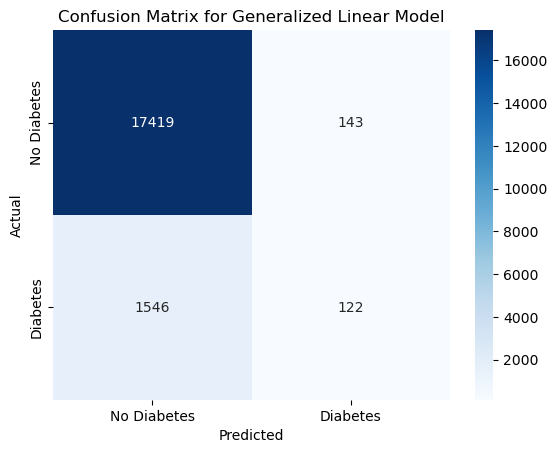

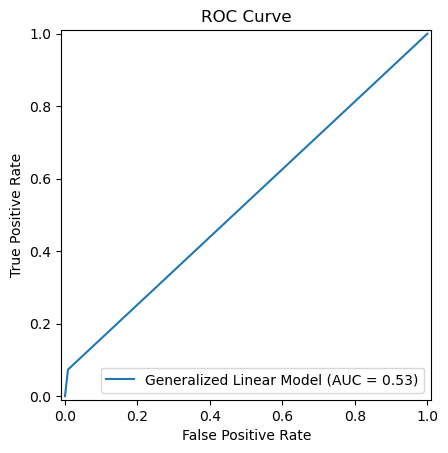

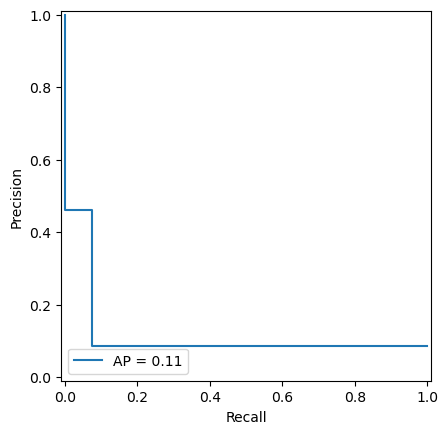

In [341]:
np.random.seed(SEED)

glm = Model("Generalized Linear Model")

glm.testTrainSplit(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
            "smoking_history_num",
            "heart_disease",
            "hypertension",
            "gender_num",
        ]
    ],
    labels=diab_clean["diabetes"],
    testSize=0.2)

fitResponse = sm.GLM(glm.y_train, glm.x_train, family=sm.families.Binomial()).fit()
display(fitResponse.summary())
glm.predict(fitResponse.predict)
glm.y_modelPredict = glm.y_modelPredict > 0.5
glm.y_prob = glm.y_modelPredict
glm.report_model_performance()
glm.rocCurve()
glm.precisionRecallCurve()


### Logistic Regression

Logistic Regression Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17562.00
Diabetes           0.87    0.63      0.73   1668.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.85  19230.00
weighted avg       0.96    0.96      0.96  19230.00


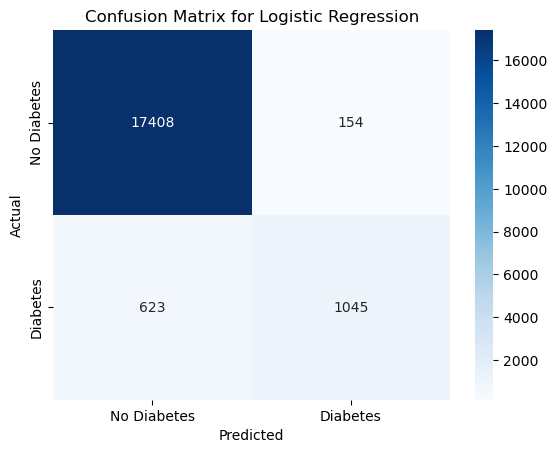

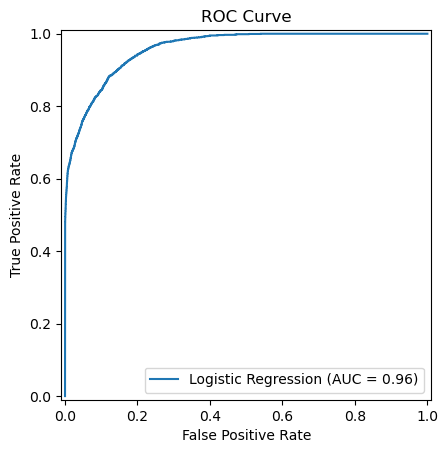

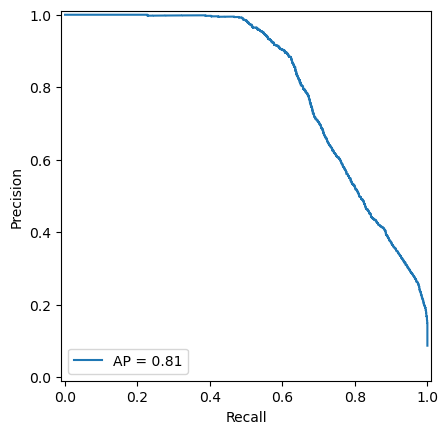

In [342]:
np.random.seed(SEED)

lr = Model("Logistic Regression")

lr.testTrainSplit(
    features= diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
        ]
    ],
    labels= diab_clean['diabetes'],
    testSize=0.2
)

lrModel = LogisticRegression()
lrModel.fit(lr.x_train, lr.y_train)
lr.predict(lrModel.predict)
lr.predictProb(lrModel.predict_proba)
lr.report_model_performance()
lr.rocCurve()
lr.precisionRecallCurve()

### KMeans Clustering

KMeans Clustering Accuracy: 0.50
              precision  recall  f1-score  support
No Diabetes        0.99    0.45      0.62  17562.0
Diabetes           0.14    0.97      0.25   1668.0
accuracy           0.50    0.50      0.50      0.5
macro avg          0.57    0.71      0.44  19230.0
weighted avg       0.92    0.50      0.59  19230.0


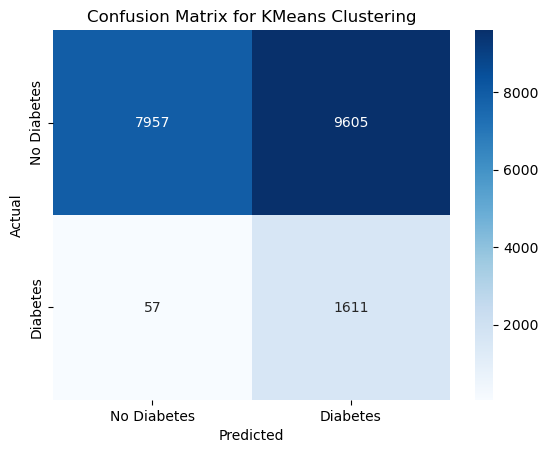

In [343]:
np.random.seed(SEED)

km = Model('KMeans Clustering')

km.testTrainSplit(
    features= diab_clean[
        ["age", 
         "bmi", 
         "blood_glucose_level"
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

scaler = StandardScaler()
kmModel = KMeans(n_clusters=2)
kmModel.fit(scaler.fit_transform(km.x_train))

km.predict(kmModel.predict, val=scaler.transform(km.x_test))
km.report_model_performance()

### K-Nearest Neighbors

K-Nearest Neighbors Accuracy: 0.97
              precision  recall  f1-score   support
No Diabetes        0.97    1.00      0.98  17562.00
Diabetes           1.00    0.68      0.81   1668.00
accuracy           0.97    0.97      0.97      0.97
macro avg          0.99    0.84      0.90  19230.00
weighted avg       0.97    0.97      0.97  19230.00


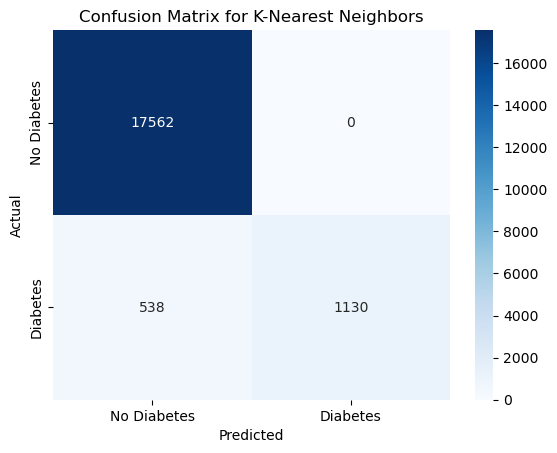

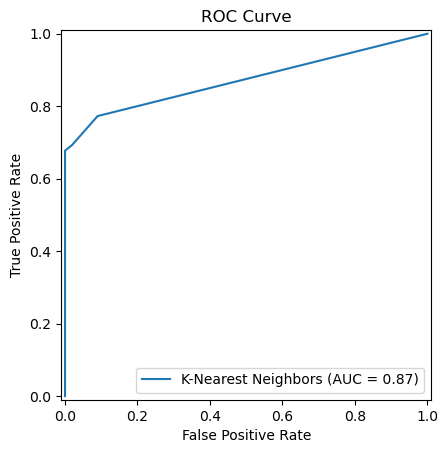

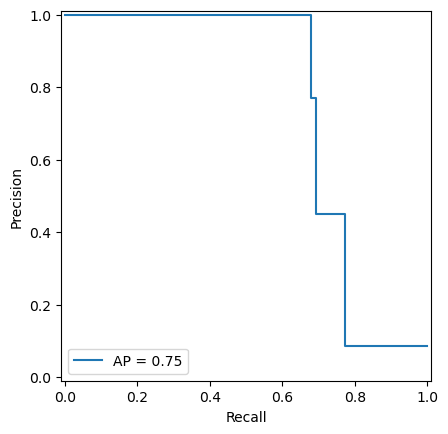

In [344]:
np.random.seed(SEED)

kn = Model("K-Nearest Neighbors")

kn.testTrainSplit(
    features=diab_clean[
        [
           'HbA1c_level',
            'blood_glucose_level' 
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

knModel = KNeighborsClassifier()
knModel.fit(kn.x_train, kn.y_train)
kn.predict(knModel.predict)
kn.predictProb(knModel.predict_proba)
kn.report_model_performance()
kn.rocCurve()
kn.precisionRecallCurve()

### Decision Tree Classifier

Decision Tree Classifier Accuracy: 0.87
              precision  recall  f1-score   support
No Diabetes        0.98    0.88      0.93  17562.00
Diabetes           0.38    0.80      0.52   1668.00
accuracy           0.87    0.87      0.87      0.87
macro avg          0.68    0.84      0.72  19230.00
weighted avg       0.93    0.87      0.89  19230.00


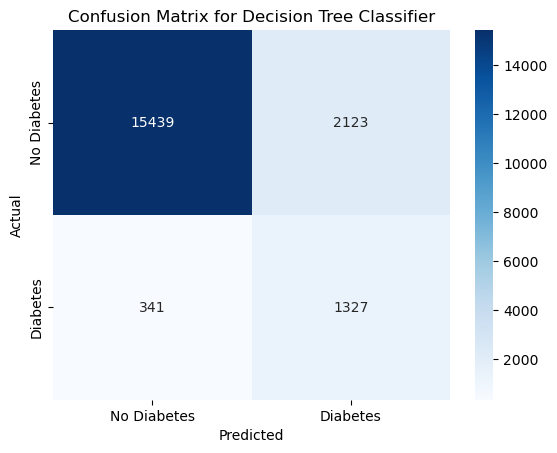

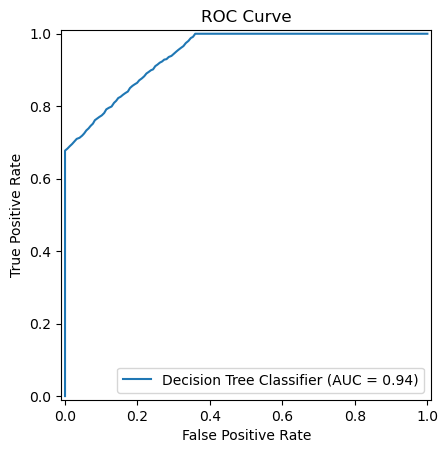

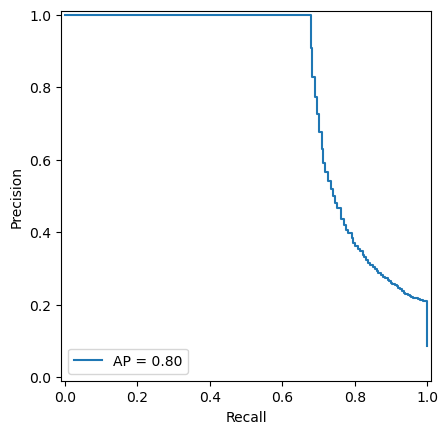

In [345]:
np.random.seed(SEED)

dtc = Model('Decision Tree Classifier')

dtc.testTrainSplit(
    features=diab_clean[
        [
             "HbA1c_level",
             "blood_glucose_level"   
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

dtcModel = tree.DecisionTreeClassifier(class_weight='balanced')
dtcModel.fit(dtc.x_train, dtc.y_train)
dtc.predict(dtcModel.predict)
dtc.predictProb(dtcModel.predict_proba)
dtc.report_model_performance()
dtc.rocCurve()
dtc.precisionRecallCurve()

### Decision Tree Classifier weighted for diabetes recall

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.67
              precision  recall  f1-score   support
No Diabetes        1.00    0.64      0.78  17555.00
Diabetes           0.21    1.00      0.35   1675.00
accuracy           0.67    0.67      0.67      0.67
macro avg          0.60    0.82      0.56  19230.00
weighted avg       0.93    0.67      0.74  19230.00


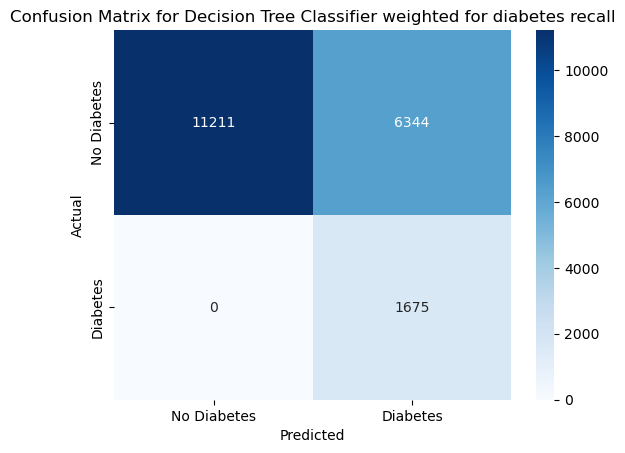

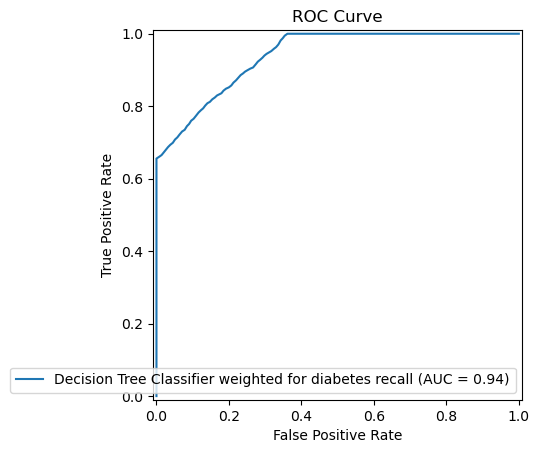

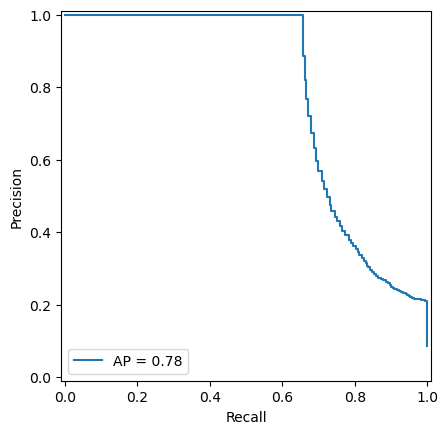

In [346]:
dtcRecall = Model('Decision Tree Classifier weighted for diabetes recall')

dtcRecall.testTrainSplit(
    features=diab_clean[
        [
             "HbA1c_level",
             "blood_glucose_level"   
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

dtcModelRecall = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
dtcModelRecall.fit(dtcRecall.x_train, dtcRecall.y_train)
dtcRecall.predict(dtcModelRecall.predict)
dtcRecall.predictProb(dtcModelRecall.predict_proba)
dtcRecall.report_model_performance()
dtcRecall.rocCurve()
dtcRecall.precisionRecallCurve()

### Decision Tree Classifier - SMOTE Resampled

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.88
              precision  recall  f1-score   support
No Diabetes        0.98    0.89      0.93  17562.00
Diabetes           0.39    0.79      0.53   1668.00
accuracy           0.88    0.88      0.88      0.88
macro avg          0.69    0.84      0.73  19230.00
weighted avg       0.93    0.88      0.89  19230.00


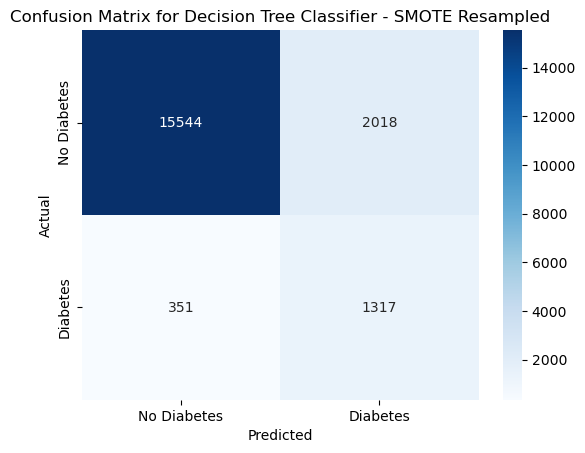

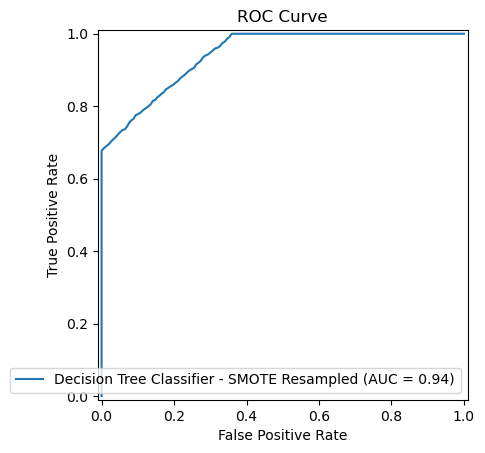

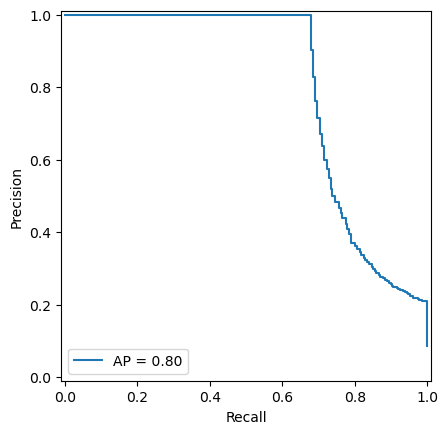

In [347]:
np.random.seed(SEED)

smote = Model('Decision Tree Classifier - SMOTE Resampled')

smote.testTrainSplit(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level"
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

smoteModel = SMOTE()

smote.x_train, smote.y_train = smoteModel.fit_resample(smote.x_train, smote.y_train)

decisionTreeSmote = tree.DecisionTreeClassifier()
decisionTreeSmote.fit(smote.x_train, smote.y_train)

smote.predict(decisionTreeSmote.predict)
smote.predictProb(decisionTreeSmote.predict_proba)
smote.report_model_performance()
smote.rocCurve()
smote.precisionRecallCurve()

## Model Analysis

In [348]:
## Model Analysis Declaration

ma = ModelAnalysis([glm, lr, km, kn , dtc, dtcRecall, smote ])



### Models Summary

,Model,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Generalized Linear Model,0.69,0.53,0.54,0.88,0.91,0.88
1,Logistic Regression,0.92,0.81,0.85,0.96,0.96,0.96
2,KMeans Clustering,0.57,0.71,0.44,0.92,0.50,0.59
3,K-Nearest Neighbors,0.99,0.84,0.90,0.97,0.97,0.97
4,Decision Tree Classifier,0.68,0.84,0.72,0.93,0.87,0.89
5,Decision Tree Classifier weighted for diabetes...,0.60,0.82,0.56,0.93,0.67,0.74
6,Decision Tree Classifier - SMOTE Resampled,0.69,0.84,0.73,0.93,0.88,0.89


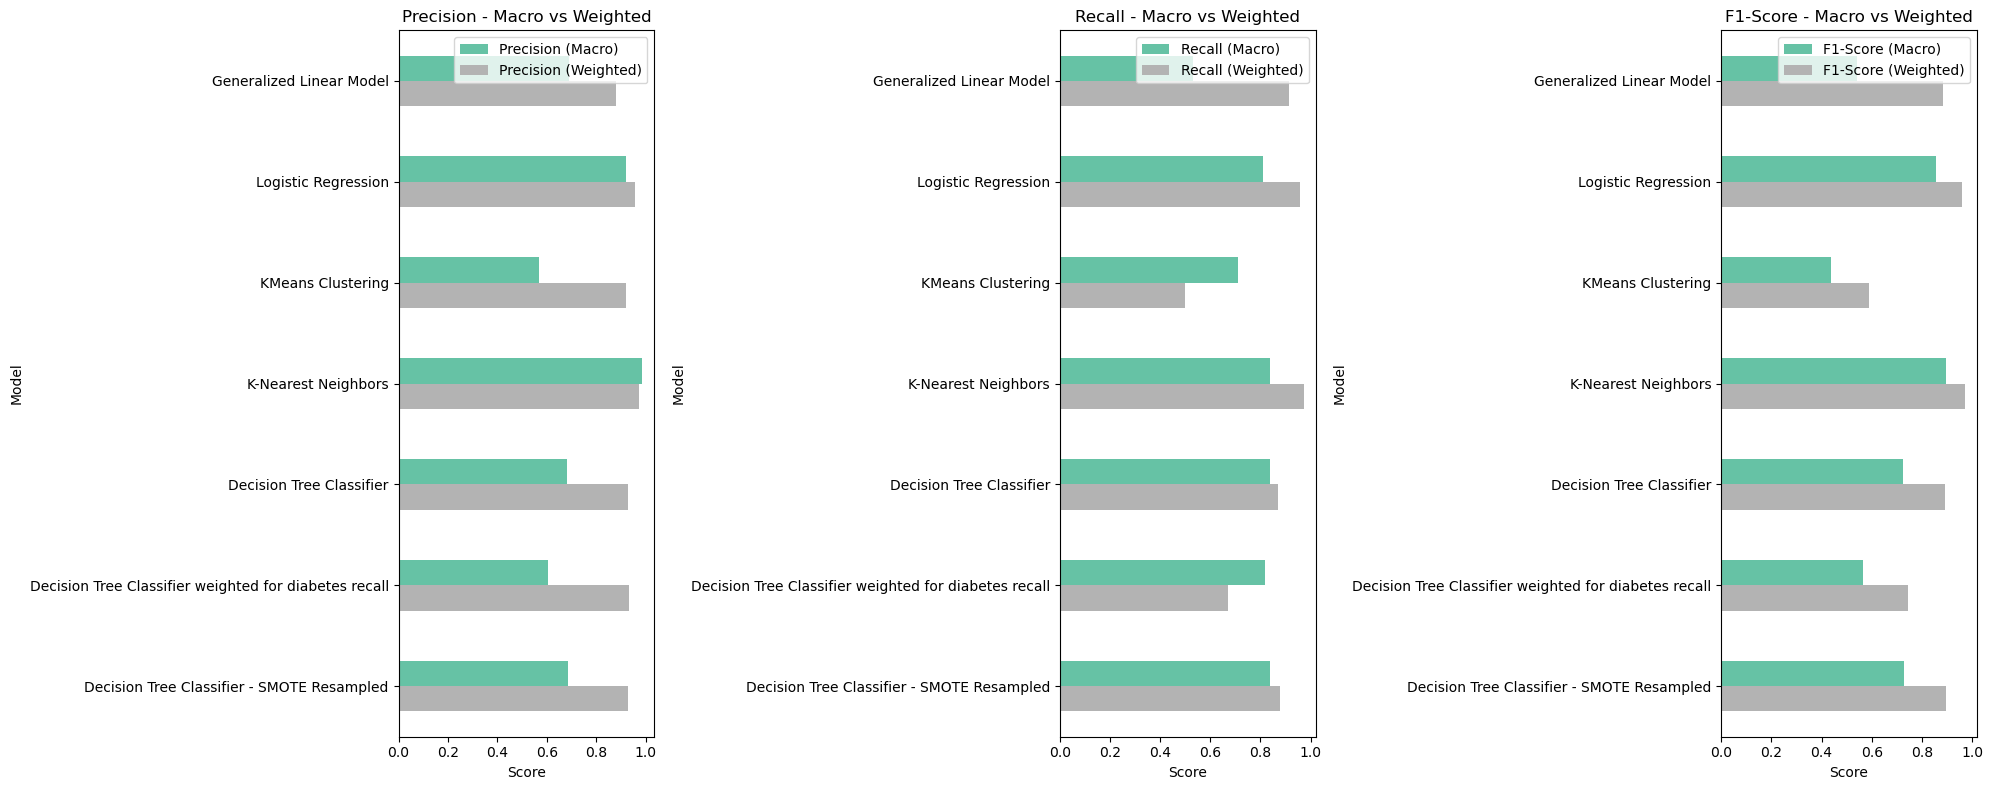

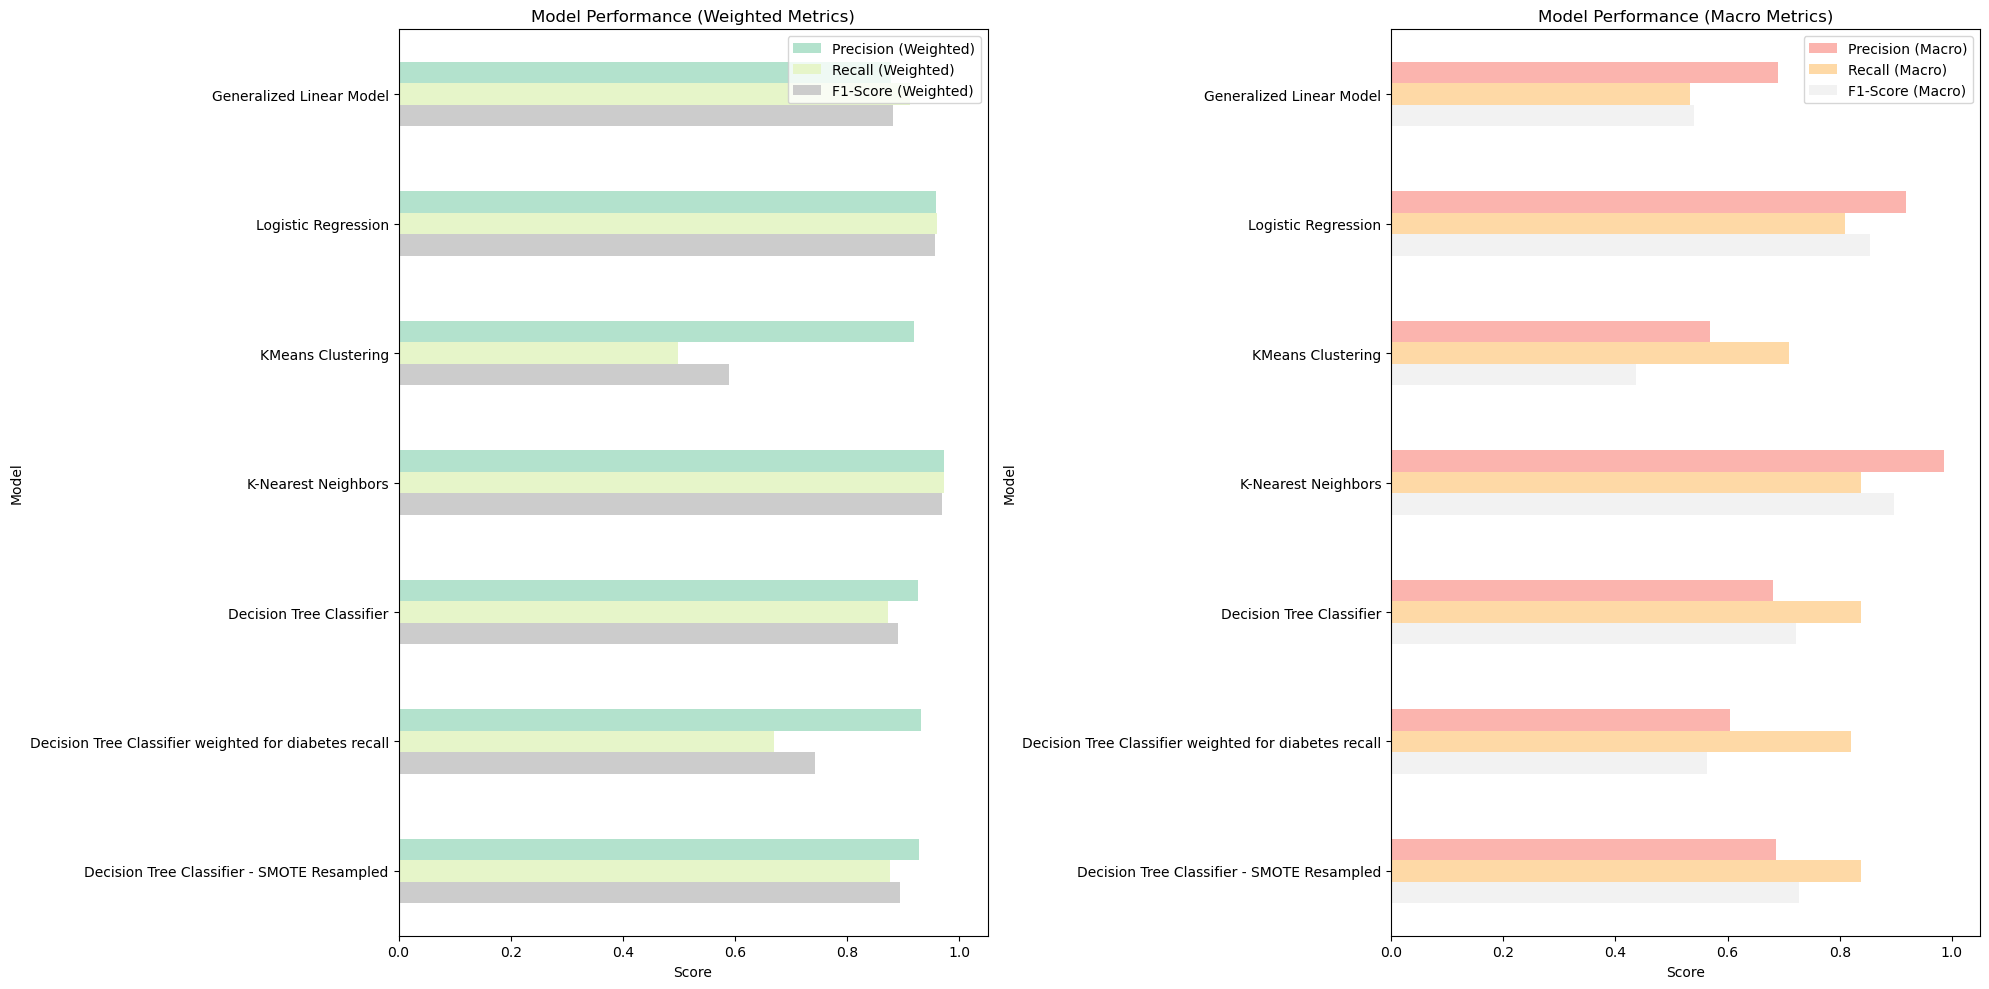

In [349]:
ma.modelAnalysisSummary()
ma.plottingMacroAndWeightedAvgs()
ma.overAllMetricsPlot()